In [ ]:
# !pip install wandb

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist, mnist
import copy
import math
from tqdm import tqdm
import joblib
import random
import wandb

#Q1

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
labels=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'] #Labels in Fashion-MNIST Dataset, i.e. list of 10 fashion items
label_indices = [-1] * len(labels)  # Initialize a list with -1 for each label
for idx, label in enumerate(train_labels):
    if label_indices[label] == -1:  # If the first occurrence isn't found yet
        label_indices[label] = idx  # Assign the current index
    if -1 not in label_indices:
      break
img = []
cap = []
for i, idx in enumerate(label_indices):
  img.append(train_images[idx])
  cap.append(labels[i])

In [ ]:
#Logging to WandB
!wandb login "90512e34eff1bdddba0f301797228f7b64f546fc"
wandb.init(project="DL_Q1")
wandb.log({"Image from each class": [wandb.Image(i, caption=cap) for i, cap in zip(img, cap)]})
wandb.finish()

#Preparing Dataset

In [2]:
def dataset(data):
  #Download, Normalize and Split the dataset into train and validation
  #In this function, we doing it to MNIST and Fashion-MNIST Dataset.
  if data == 'fashion_mnist':
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    labels=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'] #Labels in Fashion-MNIST Dataset, i.e. list of 10 fashion items
  if data =='mnist':
    (train_images, train_labels),(test_images, test_labels)=mnist.load_data()
    labels = list(range(10)) #Labels in MNIST Dataset, i.e. digits from 0 to 9
  dim = train_images.shape[1]**2
  train_images = np.reshape(train_images, [-1, dim]) #Reshaping it to 1-D array to input in neural network
  test_images = np.reshape(test_images, [-1, dim])

  #Normalizing the dataset
  train_images = train_images.astype(np.float64)
  train_images = (train_images - np.min(train_images))/(np.max(train_images)-np.min(train_images))

  test_images = test_images.astype(np.float64)
  test_images = (test_images - np.min(test_images))/(np.max(test_images)-np.min(test_images))

  num_classes = len(labels) #Number of labels

  #Splitting into train and validation set
  validation_split_percentage = 10  # 10% of the dataset should go to the validation set
  total_datapoints = train_images.shape[0]
  validation_size = int((validation_split_percentage / 100) * train_images.shape[0])

  # Calculate the size of the training set
  training_size = total_datapoints - validation_size

  # Generate indices for the dataset
  indices = np.arange(total_datapoints)

  # Shuffle indices to ensure random distribution
  np.random.shuffle(indices)

  # Split indices into training and validation sets
  train_indices = indices[:training_size]
  valid_indices = indices[training_size:]

  valid_images = train_images[valid_indices]
  train_images = train_images[train_indices]

  valid_labels = train_labels[valid_indices]
  train_labels = train_labels[train_indices]

  train_labels = np.eye(num_classes)[train_labels]
  valid_labels = np.eye(num_classes)[valid_labels]
  test_labels = np.eye(num_classes)[test_labels]

  return train_images, valid_images, test_images, train_labels, valid_labels, test_labels, labels

# Actication Functions

In [3]:
def sigmoid(z): #Sigmoid Activation Function
    return 1.0 / (1.0 + np.exp(-z))

def softmax(z): #Softmax Activation Function
    u = z - np.max(z, axis=-1, keepdims=True)
    num = np.exp(u)
    denom = np.sum(num, axis=-1, keepdims=True)
    return num / denom

def relu(z): #Relu Activation Function
    return np.maximum(0, z)

def tanh(z): #Tanh Activation Function
    return np.tanh(z)

#Gradients of Activation Functions



In [4]:
def grad_sigmoid(z): #Gradient of Sigmoid Activation Function
    return sigmoid(z) * (1 - sigmoid(z))

def grad_softmax(z): #Gradient of Softmax Activation Function
    s = softmax(z)
    return s * (1 - s)

def grad_relu(z): #Gradient of Relu Activation Function
    return 1 * (z > 0)

def grad_tanh(z): #Gradient of Tanh Activation Function
    return 1 - (np.tanh(z) ** 2)

#Weight Initialization

In [5]:
#To add a layer in Neural Network, the first layer will be input and last being output.
def hidden_layer(num_neurons, wt_init, activation, dim= None):
  layer = {} #Declaring an empty dictionary to store values of respective weights, bias and activation functions.
  if dim is not None: #Need to ensure that structure is valid. It is necessary for matrix multiplications to hold.
    if wt_init == 'random':
      layer['weight'] = np.random.normal(0,0.005, (num_neurons, dim))
      layer['bias'] = np.random.normal(0,0.005, (num_neurons, 1))
    elif wt_init == 'xavier':
      limit = limit = np.sqrt(2 / float(dim + num_neurons))
      layer['weight'] = np.random.normal(0, limit, (num_neurons, dim))
      layer['bias'] = np.random.normal(0,limit, (num_neurons, 1))
  else:
    previous_num_neurons = neural_network[-1]['h'].shape[0]
    if wt_init == 'random':
      layer['weight'] = np.random.normal(0,0.005, (num_neurons, previous_num_neurons))
      layer['bias'] = np.random.normal(0,0.005, (num_neurons, 1))
    elif wt_init == 'xavier':
      imit = limit = np.sqrt(2 / float(previous_num_neurons + num_neurons))
      layer['weight'] = np.random.normal(0, limit, (num_neurons, previous_num_neurons))
      layer['bias'] = np.random.normal(0,limit, (num_neurons, 1))
  layer['h'] = np.zeros((num_neurons, 1)) #Initializing to zeroes intially.
  layer['a'] = np.zeros((num_neurons, 1)) #Initializing to zeroes intially.
  layer['activation'] = activation #Setting activation function for added layer
  neural_network.append(layer)

# Gradient Descent Variations

In [6]:
#Basic gradient descent class
class basic_gradient_descent:
    def __init__(self, eta, num_layers, weight_decay=0.0):
        self.eta = eta #Learning rate in GD algorithm
        self.num_layers = num_layers
        self.calls = 1 #Number of calls made, to adapt learning rate
        self.l_control = 1.0 #To control learning rate
        self.weight_decay = weight_decay

    #Update in Gradient Descent
    def grad_update(self, neural_network, gradient, m):
        for i in range(self.num_layers):
            #Updating weights and biases
            neural_network[i]['weight'] = neural_network[i]['weight'] - ((self.eta / self.l_control) * gradient[i]['weight']) - (self.eta * self.weight_decay * neural_network[i]['weight'])/m
            neural_network[i]['bias'] = neural_network[i]['bias'] - ((self.eta / self.l_control) * gradient[i]['bias'])/m
        self.calls += 1
        if self.calls % 10 == 0: #Shrinking learning rate after every 10 steps to ensure it don't miss minima and diverge
            self.l_control += 1.0


#Momentum based gradient descent class
class momentum_gradient_descent:
    def __init__(self, eta, num_layers, beta, weight_decay=0.0):
        self.eta = eta #Learning rate in GD algorithm
        self.beta = beta #Momentum rate
        self.num_layers = num_layers
        self.calls = 1 #Number of calls made, to adapt learning rate
        self.l_control = 1 #To control learning rate

        self.momentum = None #Momentum push depending on previous updates
        self.weight_decay = weight_decay

    #Update in Gradient Descent
    def grad_update(self, neural_network, gradient, m):
        """
        Sutskever, I. & Martens, J. & Dahl, G. & Hinton, G.. (2013).
        On the importance of initialization and momentum in deep learning. 30th International Conference on Machine Learning, ICML 2013. 1139-1147.
        """
        beta = min(1 - 2 ** (-1 - math.log((self.calls / 250.0) + 1, 2)), self.beta) #Adaptive momentum as suggested by Sutskever et. al., 2013
        if self.momentum is None:
            self.momentum = copy.deepcopy(gradient) #Copying the structure
            #Initialization of momentum
            for i in range(self.num_layers):
                self.momentum[i]['weight'] = (self.eta / self.l_control) * gradient[i]['weight']/m
                self.momentum[i]['bias'] = (self.eta / self.l_control) * gradient[i]['bias']/m
        else:
            #Update in momentum
            for i in range(self.num_layers):
                self.momentum[i]['weight'] = beta * self.momentum[i]['weight'] + (self.eta / self.l_control) * gradient[i]['weight']/m
                self.momentum[i]['bias'] = beta * self.momentum[i]['bias'] + (self.eta / self.l_control) * gradient[i]['bias']/m
        #Updates depending on history and present component
        for i in range(self.num_layers):
            #Updating weight and biases
            neural_network[i]['weight'] = neural_network[i]['weight'] - self.momentum[i]['weight'] - ((self.eta / self.l_control) * self.weight_decay * neural_network[i]['weight'])/m
            neural_network[i]['bias'] = neural_network[i]['bias'] - self.momentum[i]['bias']

        self.calls += 1
        if self.calls % 10 == 0: #Shrinking learning rate after every 10 steps to ensure it don't miss minima and diverge
            self.l_control += 1.0


#Nesterov Accelerated gradient descent class
class nestrov_gradient_descent:
    def __init__(self, eta, num_layers, beta, weight_decay=0.0):
        self.eta = eta #Learning rate in GD algorithm
        self.beta = beta #Momentum rate
        self.num_layers = num_layers
        self.calls = 1 #Number of calls made, to adapt learning rate
        self.l_control = 1 #To control learning rate

        self.momentum = None #Momentum push depending on previous updates
        self.weight_decay = weight_decay

    #Lookahead point based on history movement
    def history_movement(self, neural_network):
        if self.momentum is None:  #As momentum begin only when we have some past movements
            pass
        else:
            for i in range(self.num_layers):
                neural_network[i]['weight'] -= self.beta * self.momentum[i]['weight']
                neural_network[i]['bias'] -= self.beta * self.momentum[i]['bias']

    #Update in Gradient Descent
    def grad_update(self, neural_network, gradient, m):
        for i in range(self.num_layers):
            #Updating weights and biases
            neural_network[i]['weight'] = neural_network[i]['weight'] - ((self.eta / self.l_control) * gradient[i]['weight'])/m - ((self.eta / self.l_control) * self.weight_decay * neural_network[i]['weight'])/m
            neural_network[i]['bias'] -= self.eta * gradient[i]['bias']/m

        beta = min(1 - 2 ** (-1 - math.log((self.calls / 250.0) + 1, 2)), self.beta) #Adaptive momentum as suggested by Sutskever et. al., 2013

        if self.momentum is None:
            self.momentum = copy.deepcopy(gradient) #Copying the structure
            for i in range(self.num_layers):
                self.momentum[i]['weight'] = (self.eta / self.l_control) * gradient[i]['weight']/m
                self.momentum[i]['bias'] = (self.eta / self.l_control) * gradient[i]['bias']/m
        else:
            #Update in momentum
            for i in range(self.num_layers):
                self.momentum[i]['weight'] = beta * self.momentum[i]['weight'] + ((self.eta / self.l_control) * gradient[i]['weight'])/m
                self.momentum[i]['bias'] = beta * self.momentum[i]['bias'] + ((self.eta / self.l_control) * gradient[i]['bias'])/m

        self.calls += 1
        if self.calls % 10 == 0: #Shrinking learning rate after every 10 steps to ensure it don't miss minima and diverge
            self.l_control += 1.0


#RMSprop gradient descent class
class RMSprop_gradient_descent:
    def __init__(self, eta, num_layers, beta, weight_decay=0.0, epsilon = 1e-3):
        self.eta = eta #Learning rate in GD algorithm
        self.beta = beta #Decay rate for moving average
        self.num_layers = num_layers
        self.calls = 1 #Number of calls made. No need to adapt learning rate in this algorithm.
        self.epsilon = epsilon

        self.update = None
        self.weight_decay = weight_decay

    #Update in Gradient Descent
    def grad_update(self, neural_network, gradient, m):
        if self.update is None:
            self.update = copy.deepcopy(gradient) #Copying the structure
            for i in range(self.num_layers):
                self.update[i]['weight'] = (1 - self.beta) * (gradient[i]['weight']/m) ** 2
                self.update[i]['bias'] = (1 - self.beta) * (gradient[i]['bias']/m) ** 2
        else:
            for i in range(self.num_layers):
                self.update[i]['weight'] = self.beta * self.update[i]['weight'] + (1 - self.beta) * (gradient[i]['weight']/m) ** 2
                self.update[i]['bias'] = self.beta * self.update[i]['bias'] + (1 - self.beta) * (gradient[i]['bias']/m) ** 2
        #Update rule for RMSProp
        for i in range(self.num_layers):
            #updating weight and biases
            neural_network[i]['weight'] = neural_network[i]['weight'] - np.multiply((self.eta / np.sqrt(self.update[i]['weight'] + self.epsilon)),gradient[i]['weight']/m) - self.eta*self.weight_decay * neural_network[i]['weight']/m
            neural_network[i]['bias'] = neural_network[i]['bias'] - np.multiply((self.eta / np.sqrt(self.update[i]['bias'] + self.epsilon)), gradient[i]['bias']/m)

        self.calls += 1


#Adam gradient descent class
class adam_gradient_descent:
    def __init__(self, eta, num_layers, weight_decay=0.0, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.eta = eta #Learning rate in GD algorithm
        self.beta1 = beta1 #Decay rate for moving average of first moments
        self.beta2 = beta2 #Decay rate for moving average of second moments
        self.num_layers = num_layers
        self.calls = 1 #Number of calls made. No need to adapt learning rate in this algorithm.

        self.momentum = None #First moment vectors initialized to None, as momentum is when we have past movements.
        self.momentum_hat = None

        self.second_momentum = None #Second moment vectors initialized to None, as momentum is when we have past movements.
        self.second_momentum_hat = None

        self.epsilon = epsilon
        self.weight_decay = weight_decay

    #Update in Gradient Descent
    def grad_update(self, neural_network, gradient,m):
        if self.momentum is None:
            self.momentum = copy.deepcopy(gradient) #Copying the structure
            self.second_momentum = copy.deepcopy(gradient)
            for i in range(self.num_layers):
                self.momentum[i]['weight'][:] = np.zeros_like(gradient[i]['weight'])
                self.momentum[i]['bias'][:] = np.zeros_like(gradient[i]['bias'])
                self.second_momentum[i]['weight'][:] = np.zeros_like(gradient[i]['weight'])
                self.second_momentum[i]['bias'][:] = np.zeros_like(gradient[i]['bias'])
            self.momentum_hat = copy.deepcopy(self.momentum) #Copying the structure
            self.second_momentum_hat = copy.deepcopy(self.second_momentum)

        for i in range(self.num_layers):
            #Updating the first and moment estimate
            self.momentum[i]['weight'] = self.beta1 * self.momentum[i]['weight'] + (1 - self.beta1) * gradient[i]['weight']/m
            self.momentum[i]['bias'] = self.beta1 * self.momentum[i]['bias'] + (1 - self.beta1) * gradient[i]['bias']/m

            self.second_momentum[i]['weight'] = self.beta2 * self.second_momentum[i]['weight'] + (1 - self.beta2) * np.power(gradient[i]['weight']/m, 2)
            self.second_momentum[i]['bias'] = self.beta2 * self.second_momentum[i]['bias'] + (1 - self.beta2) * np.power(gradient[i]['bias']/m, 2)

        for i in range(self.num_layers):
            self.momentum_hat[i]['weight'][:] = (1 / (1 - (self.beta1 ** self.calls))) * self.momentum[i]['weight']
            self.momentum_hat[i]['bias'][:] = (1 / (1 - (self.beta1 ** self.calls))) * self.momentum[i]['bias']

            self.second_momentum_hat[i]['weight'][:] = (1 / (1 - (self.beta2 ** self.calls))) * self.second_momentum[i]['weight']
            self.second_momentum_hat[i]['bias'][:] = (1 / (1 - (self.beta2 ** self.calls))) * self.second_momentum[i]['bias']

        for i in range(self.num_layers):
            #Updating weight and biases
            denom_w = 1/(np.sqrt(self.second_momentum_hat[i]['weight']) + self.epsilon)
            neural_network[i]['weight'] = neural_network[i]['weight'] - self.eta * (np.multiply(denom_w, self.momentum_hat[i]['weight'])) - (self.eta * self.weight_decay * neural_network[i]['weight'])/m

            denom_b = 1/(np.sqrt(self.second_momentum_hat[i]['bias'])+ self.epsilon)
            neural_network[i]['bias'] -= self.eta * np.multiply(denom_b, self.momentum_hat[i]['bias'])

        self.calls += 1

#Nadam gradient descent class
class nadam_gradient_descent:
    def __init__(self, eta, num_layers, weight_decay=0.0, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.eta = eta #Learning rate in GD algorithm
        self.beta1 = beta1 #Decay rate for moving average of first moments
        self.beta2 = beta2 #Decay rate for moving average of second moments
        self.num_layers = num_layers
        self.calls = 1 #Number of calls made. No need to adapt learning rate in this algorithm.

        self.momentum = None #First moment vector
        self.momentum_hat = None

        self.second_momentum = None #Second moment vector
        self.second_momentum_hat = None

        self.epsilon = epsilon
        self.weight_decay = weight_decay

    #Update in Gradient Descent
    def grad_update(self, neural_network, gradient, m):
        if self.momentum is None:
            self.momentum = copy.deepcopy(gradient) #Copying the structure
            self.second_momentum = copy.deepcopy(gradient)
            for i in range(self.num_layers):
                self.momentum[i]['weight'] = (1 - self.beta1) * gradient[i]['weight']/m
                self.momentum[i]['bias'] = (1 - self.beta1) * gradient[i]['bias']/m

                self.second_momentum[i]['weight'] = (1 - self.beta2) * np.power(gradient[i]['weight']/m, 2)
                self.second_momentum[i]['bias'] = (1 - self.beta2) * np.power(gradient[i]['bias']/m, 2)
        else:
            for i in range(self.num_layers):
                #Updating the first and second moment estimates
                self.momentum[i]['weight'] = self.beta1 * self.momentum[i]['weight'] + (1 - self.beta1) * gradient[i]['weight']/m
                self.momentum[i]['bias'] = self.beta1 * self.momentum[i]['bias'] + (1 - self.beta1) * gradient[i]['bias']/m

                self.second_momentum[i]['weight'] = self.beta2 * self.second_momentum[i]['weight'] + (1 - self.beta2) * np.power(gradient[i]['weight']/m, 2)
                self.second_momentum[i]['bias'] = self.beta2 * self.second_momentum[i]['bias'] + (1 - self.beta2) * np.power(gradient[i]['bias']/m, 2)

        momentum_hat = copy.deepcopy(self.momentum) #Copying the structure
        second_momentum_hat = copy.deepcopy(self.second_momentum)
        for i in range(self.num_layers):
            momentum_hat[i]['weight'] = (self.beta1 / (1 - (self.beta1 ** self.calls))) * self.momentum[i]['weight'] + ((1 - self.beta1) / (1 - (self.beta1 ** self.calls))) * gradient[i]['weight']
            momentum_hat[i]['bias'] = (self.beta1 / (1 - (self.beta1 ** self.calls))) * self.momentum[i]['bias'] + ((1 - self.beta1) / (1 - (self.beta1 ** self.calls))) * gradient[i]['bias']

            second_momentum_hat[i]['weight'] = (self.beta2 / (1 - (self.beta2 ** self.calls))) * self.second_momentum[i]['weight']
            second_momentum_hat[i]['bias'] = (self.beta2 / (1 - (self.beta2 ** self.calls))) * self.second_momentum[i]['bias']

        for i in range(self.num_layers):
            #Updating weight and biases
            denom_w = 1/(np.sqrt(self.second_momentum[i]['weight'] + self.epsilon))
            neural_network[i]['weight'] = neural_network[i]['weight'] - self.eta * (np.multiply(denom_w, momentum_hat[i]['weight'])) - (self.eta * self.weight_decay * neural_network[i]['weight'])/m

            denom_b = 1/(np.sqrt(self.second_momentum[i]['bias']) + self.epsilon)
            neural_network[i]['bias'] -= self.eta * np.multiply(denom_b, second_momentum_hat[i]['bias'])

        self.calls += 1

#Loss Functions

In [7]:
def cross_entropy(y, y_hat_vector, L):   #y = true label and y_hat_vector = softmax output
    m = y.shape[0]  # Number of samples

    # L2 Regularization Loss
    L2_regularization_loss = 0
    for i in range(1, L):  # Start from 1 as index 0 is for the input layer of neural network
        L2_regularization_loss += np.sum(np.square(neural_network[i]['weight']))
    L2_regularization_loss = L2_regularization_loss/ (2 * m)

    # Cross-Entropy Loss
    cross_entropy_loss = -np.sum(y * np.log(y_hat_vector + 1e-9)) / m

    # Total Loss is the sum of above two quantities
    total_loss = cross_entropy_loss + L2_regularization_loss

    return total_loss

In [8]:
def squared_loss(y, y_hat_vector, L):     #y = true label and y_hat_vector = softmax output
  m = y.shape[0]
  #L2 Regularization Loss
  L2_regularization_loss = 0
  for i in range(1, L):  # Start from 1 as index 0 is for input layer
    L2_regularization_loss += np.sum(np.square(neural_network[i]['weight']))
  L2_regularization_loss = L2_regularization_loss/ (2 * m)
  #Mean-squared error loss
  mse_loss = (np.linalg.norm(y-y_hat_vector)**2)/m

  #Total Loss is the sum of above two quantities
  total_loss = mse_loss + L2_regularization_loss

  return total_loss

# Loss and Accuracy

In [9]:
def loss_acc_calc(L, X, y, loss_type):
    loss = 0
    acc = 0
    if loss_type == 'cross_entropy':
        forward_propagation(L, X)
        loss = cross_entropy(y, neural_network[L - 1]['h'], L)
        y_pred = np.argmax(neural_network[L - 1]['h'], axis=1)
        y_true = np.argmax(y, axis=1)
        acc = np.sum(y_pred == y_true)/y_true.shape[0]

    elif loss_type == 'mean_squared_error':
        forward_propagation(L, X)
        loss = squared_loss(y, neural_network[L - 1]['h'],L)
        y_pred = np.argmax(neural_network[L - 1]['h'], axis=1)
        y_true = np.argmax(y, axis=1)
        acc = np.sum(y_pred == y_true)/y_true.shape[0]
    return [loss, acc]

# Forward Propagation

In [10]:
def forward_propagation(L, X):
    for i in range(L):
        if i == 0:  #We have input layer, X, as our first layer
            neural_network[i]['a'] = np.dot(X, neural_network[i]['weight'].T) + neural_network[i]['bias'].T
        else:
            neural_network[i]['a'] = np.dot(neural_network[i-1]['h'], neural_network[i]['weight'].T) + neural_network[i]['bias'].reshape(-1)

        if neural_network[i]['activation'] == 'sigmoid':
          neural_network[i]['h'] = sigmoid(neural_network[i]['a'])
        elif neural_network[i]['activation'] == 'softmax':
          neural_network[i]['h'] = softmax(neural_network[i]['a'])
        elif neural_network[i]['activation'] == 'relu':
          neural_network[i]['h'] = relu(neural_network[i]['a'])
        elif neural_network[i]['activation'] == 'tanh':
          neural_network[i]['h'] = tanh(neural_network[i]['a'])

# Back Propagation

In [11]:
def back_propagation(L, X, y, loss_type):
  if loss_type == 'cross_entropy':
    gradient[L-1]['a'] = neural_network[L-1]['h'] - y
  if loss_type == 'mean_squared_error':
    gradient[L-1]['a'] = np.multiply((neural_network[L-1]['h']-y), grad_softmax(neural_network[L-1]['a']))
  for i in range(L-1, 0, -1):
    gradient[i]['weight'] = np.matmul(gradient[i]['a'].T, (neural_network[i-1]['h']))
    gradient[i]['bias'] = np.sum(gradient[i]['a'], axis = 0).reshape(-1,1)
    gradient[i-1]['h'] = np.matmul(gradient[i]['a'], neural_network[i]['weight'])

    if neural_network[i-1]['activation'] == 'sigmoid':
      gradient[i-1]['a'] = np.multiply(gradient[i-1]['h'], grad_sigmoid(neural_network[i-1]['a']))
    elif neural_network[i-1]['activation'] == 'softmax':
      gradient[i-1]['a'] = np.multiply(gradient[i-1]['h'], grad_softmax(neural_network[i-1]['a']))
    elif neural_network[i-1]['activation'] == 'relu':
      gradient[i-1]['a'] = np.multiply(gradient[i-1]['h'], grad_relu(neural_network[i-1]['a']))
    elif neural_network[i-1]['activation'] == 'tanh':
      gradient[i-1]['a'] = np.multiply(gradient[i-1]['h'], grad_tanh(neural_network[i-1]['a']))

In [ ]:
X_train, X_valid, X_test, y_train, y_valid, y_test, labels = dataset('fashion_mnist')

#Fitting Data

In [13]:
def train_and_evaluate(X_train, X_valid, y_train, y_valid, batch, epochs, opt, loss_type):
    L = len(neural_network)  #Number of layers in neural network including input and output layer
    #Loop for epoch iterations
    for k in tqdm(range(epochs)):
        for i in range(int(X_train.shape[0]/batch)):
            global loss
            loss = 0
            indices = np.random.choice(range(X_train.shape[0]), batch) #Sample indices of a batch
            x_batch = X_train[indices]
            y_batch = y_train[indices]
            if isinstance(opt, nestrov_gradient_descent): #For Nestrov gradient descent, we go to lookahead point and then compute gradient
                opt.history_movement(neural_network=neural_network)

            forward_propagation(L, x_batch)
            back_propagation(L, x_batch, y_batch, loss_type=loss_type)
            opt.grad_update(neural_network=neural_network, gradient=gradient, m = x_batch.shape[0])

        #Computing loss and accuracy on train and validation set of datapoints
        validation_result = loss_acc_calc(L, X= X_valid, y= y_valid,loss_type=loss_type)
        training_result = loss_acc_calc(L, X=X_train, y=y_train, loss_type=loss_type)

        #Logging to WandB
        wandb.log({"val_accuracy": validation_result[1], 'val_loss': validation_result[0],
                   'train_accuracy': training_result[1], 'train_loss': training_result[0], 'epoch': k + 1})

        if np.isnan(validation_result[0]):
            return

# Initializing Neural Network

In [14]:
def initialize_fit_model(batch, epochs, output_dim, activation, opt, num_layers, hidden_layer_sizes, weight_init='xavier',loss_type='cross_entropy'):

    n_features = 784
    global neural_network
    global gradient
    neural_network = []
    gradient = []

    selected_sizes = np.full(num_layers-1, hidden_layer_sizes)

    for i, layer_size in enumerate(selected_sizes):
        if i == 0:
            # For the first layer, specify the input dimension
            hidden_layer(num_neurons= layer_size, activation=activation, dim=784, wt_init=weight_init)
        else:
            # Subsequent layers infer their input dimension from the previous layer's output
            hidden_layer(num_neurons= layer_size, activation=activation, wt_init=weight_init)

    # Adding the output layer
    hidden_layer(num_neurons=output_dim, activation='softmax', wt_init=weight_init)

    """Replicate the structure of neural_network."""
    gradient = copy.deepcopy(neural_network)

    train_and_evaluate(X_train, X_valid, y_train, y_valid, batch=batch, epochs=epochs, opt=opt,loss_type=loss_type)
    return neural_network

In [ ]:
def network_train():
    #Best Configuration
    config={"batch_size" :128, "epoch":10, "activation":'tanh', "optimiser":"adam", "num_layers" : 5,"hidden_layer_sizes" :128 ,"weight_init":'xavier',"loss":'cross_entropy',"learning_rate":	0.0001, "weight_decay":0.5}
    run=wandb.init(config=config,project="val_performance")
    # run=wandb.init(config=config,project="Code check")
    ##### while selecting the best model after sweep#########
    # run=wandb.init(project="best_model_saving",config=config)
    #run=wandb.init(project="test_accuracy",config=config)
    opti = None
    wandb.run.name = 'hln' + str(run.config.num_layers) + 'hls' + str(run.config.hidden_layer_sizes) + 'bs_' + str(run.config.batch_size) + '_act_' + run.config.activation + '_opt_' + str(
        run.config.optimiser) + '_ini_' + str(run.config.weight_init) + '_epoch' + str(run.config.epoch) + '_lr_' + str(
        round(run.config.learning_rate, 4)) + 'wd' + str(run.config.weight_decay) #Naming each run in wandb, to ensure parameter values are understandable from the respective run name.
    if run.config.optimiser == 'nag':
        opti = nestrov_gradient_descent(num_layers = run.config.num_layers, eta=run.config.learning_rate, beta=.90, weight_decay=run.config.weight_decay)
    elif run.config.optimiser == 'rmsprop':
        opti = RMSprop_gradient_descent(num_layers = run.config.num_layers, eta=run.config.learning_rate, beta=.90, weight_decay=run.config.weight_decay)
    elif run.config.optimiser == 'sgd':
        opti = basic_gradient_descent(num_layers = run.config.num_layers, eta=run.config.learning_rate, weight_decay=run.config.weight_decay)
    elif run.config.optimiser == 'momentum':
        opti = momentum_gradient_descent(num_layers = run.config.num_layers, eta=run.config.learning_rate, beta=.99,
                                       weight_decay=run.config.weight_decay)
    elif run.config.optimiser == 'adam':
        opti = adam_gradient_descent(num_layers = run.config.num_layers, eta=run.config.learning_rate, weight_decay=run.config.weight_decay)
    elif run.config.optimiser == 'nadam':
        opti = nadam_gradient_descent(num_layers = run.config.num_layers, eta=run.config.learning_rate, weight_decay=run.config.weight_decay)

    final_neural_network=initialize_fit_model(epochs=run.config.epoch, batch=run.config.batch_size, output_dim=10,
           opt=opti, weight_init=run.config.weight_init, activation=run.config.activation, num_layers = run.config.num_layers, hidden_layer_sizes = run.config.hidden_layer_sizes , loss_type=run.config.loss)

    return final_neural_network

# Execute Algorithm

##Sweep Config for Random method

In [ ]:
# sweep_config={
#     "method": "random",
#     "metric":{
#         "name":"val_accuracy",
#         "goal":"maximize"
#     },
#     "parameters":{
#         "batch_size":{
#             "values":[16, 64, 128, 256]
#         },
#          "epoch":{
#             "values":[3, 5, 10]
#         },
#          "activation":{
#             "values":["relu", "tanh", "sigmoid"]
#         },
#          "optimiser":{
#             "values":["sgd", "momentum", "nag", "rmsprop", "adam", "nadam"]
#         },
#          "num_layers":{
#             "values":[3, 4, 5, 6]
#         },
#          "hidden_layer_sizes":{
#             "values":[32, 64, 128]
#         },
#         "weight_init":{
#             "values":["xavier", "random"]
#         },
#          "learning_rate":{
#             "values":[0.01, 0.0001, 0.001]
#         },
#         "weight_decay":{
#             "values":[0, 0.325, 0.5]
#         }
#     }
#   }

## Sweep Config for bayes method

In [ ]:
#After shrinking the possible set of values of hyperparameters depending on past runs in random method wandb sweep
sweep_config={
    "method": "bayes",
    "metric":{
        "name":"val_accuracy",
        "goal":"maximize"
    },
    "parameters":{
        "batch_size":{
            "values":[64, 128]
        },
         "epoch":{
            "values":[3, 5, 10]
        },
         "activation":{
            "values":["tanh", "sigmoid"]
        },
         "optimiser":{
            "values":["rmsprop", "adam", "nadam"]
        },
         "num_layers":{
            "values":[4, 5, 6]
        },
         "hidden_layer_sizes":{
            "values":[32, 64, 128]
        },
        "weight_init":{
            "values":["xavier"]
        },
         "learning_rate":{
            "values":[0.01, 0.0001]
        },
        "weight_decay":{
            "values":[0, 0.5]
        }
    }
  }

In [ ]:
!wandb login "90512e34eff1bdddba0f301797228f7b64f546fc"

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
sweep_id=wandb.sweep(sweep_config,entity="cs22s027",project="val_performance")

Create sweep with ID: byo3n9tv
Sweep URL: https://wandb.ai/cs22s027/Code%20check/sweeps/byo3n9tv


In [ ]:
wandb.agent(sweep_id,function=network_train, count = 100)

wandb: Agent Starting Run: rjlz57kg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 3
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 33%|███▎      | 1/3 [00:25<00:50, 25.00s/it]<ipython-input-4-216a1c4f57ef>:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
100%|██████████| 3/3 [01:14<00:00, 24.73s/it]


epoch,▁▅█
train_accuracy,▄▁█
train_loss,█▂▁
val_accuracy,▅█▁
val_loss,▄▁█
epoch,3
train_accuracy,0.1002
train_loss,2.30719
val_accuracy,0.09817
val_loss,2.33632


wandb: Agent Starting Run: 5klpgv8i with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 4
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 5/5 [02:03<00:00, 24.75s/it]


epoch,▁▃▅▆█
train_accuracy,▅█▁▇▄
train_loss,█▆▅▂▁
val_accuracy,▄▁█▂▅
val_loss,█▆▄▂▁
epoch,5
train_accuracy,0.09959
train_loss,11.34329
val_accuracy,0.10367
val_loss,81.96636


wandb: Agent Starting Run: ak9wblwo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 5/5 [00:49<00:00,  9.88s/it]


epoch,▁▃▅▆█
train_accuracy,█▃▁▁▅
train_loss,█▁▅▂▅
val_accuracy,▁▆██▄
val_loss,█▂▁▁▄
epoch,5
train_accuracy,0.10015
train_loss,2.30498
val_accuracy,0.09867
val_loss,2.30529


wandb: Agent Starting Run: fvpnwyrp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [02:39<00:00, 15.93s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▆▆▆▆▁█▁█▅▅
train_loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,▃▃▃▃█▁█▁▄▄
val_loss,█▇▆▅▅▄▃▂▂▁
epoch,10
train_accuracy,0.10015
train_loss,75.22543
val_accuracy,0.09867
val_loss,658.5473


wandb: Agent Starting Run: zp60j3jd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [01:40<00:00, 10.09s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▆██▄▆▁▆█▁
train_loss,▇██▄▂▁▂▂▆▃
val_accuracy,▁▃▁▁▅▃█▃▁█
val_loss,▄▆█▅▁▂▁▄▆▃
epoch,10
train_accuracy,0.09922
train_loss,2.30419
val_accuracy,0.107
val_loss,2.30414


wandb: Agent Starting Run: kqearl8d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 5/5 [00:34<00:00,  7.00s/it]


epoch,▁▃▅▆█
train_accuracy,▁▄▅▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▅▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.52237
train_loss,1.2644
val_accuracy,0.52183
val_loss,1.33639


wandb: Agent Starting Run: 5zr8sgo5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [01:44<00:00, 10.44s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▅▅█▇▃▃▁█▅▇
train_loss,█▅▃▄▆▁▂▄▂▄
val_accuracy,▄▄▁▂▆▆█▁▄▂
val_loss,▇▄▅█▆▃▁▅▂▅
epoch,10
train_accuracy,0.10046
train_loss,2.31053
val_accuracy,0.09583
val_loss,2.36491


wandb: Agent Starting Run: 3zz7r4v5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [01:09<00:00,  6.94s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁█▄▅▄▄▄▅▄▄
train_loss,▅▁▄▃▃▄█▅██
val_accuracy,█▁▅▄▅▅▅▄▅▅
val_loss,▁▁▃▂▂▃▄▄▆█
epoch,10
train_accuracy,0.10015
train_loss,2.30283
val_accuracy,0.09867
val_loss,2.30462


wandb: Agent Starting Run: kflpod96 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [01:34<00:00,  9.45s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▂▂▄▄▅▅▇█
train_loss,██▇▆▅▅▄▄▂▁
val_accuracy,▁▁▂▂▄▄▅▅▇█
val_loss,██▇▆▅▅▄▄▂▁
epoch,10
train_accuracy,0.65981
train_loss,0.88933
val_accuracy,0.656
val_loss,1.00483


wandb: Agent Starting Run: em67blat with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 5/5 [00:37<00:00,  7.55s/it]


epoch,▁▃▅▆█
train_accuracy,▁▄▇██
train_loss,█▄▂▂▁
val_accuracy,▁▄▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.42326
train_loss,1.38988
val_accuracy,0.41933
val_loss,1.4655


wandb: Agent Starting Run: 6jto83oi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [01:09<00:00,  6.98s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁██
train_loss,█▇▄▃▃▃▃▂▁▁
val_accuracy,▃▁▁▃▃▃▃▃██
val_loss,█▇▃▂▂▂▃▂▁▁
epoch,10
train_accuracy,0.11857
train_loss,1.97989
val_accuracy,0.11933
val_loss,2.08511


wandb: Agent Starting Run: 01s7y2ef with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 5/5 [00:34<00:00,  6.98s/it]


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.61385
train_loss,1.03423
val_accuracy,0.61617
val_loss,1.11557


wandb: Agent Starting Run: i35smvnh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 5/5 [00:33<00:00,  6.62s/it]


epoch,▁▃▅▆█
train_accuracy,▁▁▁▄█
train_loss,█▆▅▄▁
val_accuracy,▁▁▁▄█
val_loss,█▆▅▄▁
epoch,5
train_accuracy,0.32407
train_loss,2.27485
val_accuracy,0.32517
val_loss,2.28455


wandb: Agent Starting Run: copwuyyn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 5/5 [00:52<00:00, 10.45s/it]


epoch,▁▃▅▆█
train_accuracy,▁▂▃▁█
train_loss,███▂▁
val_accuracy,▁▂▃▁█
val_loss,███▂▁
epoch,5
train_accuracy,0.14902
train_loss,1.99828
val_accuracy,0.14983
val_loss,2.0488


wandb: Agent Starting Run: rp6r0vq8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 5/5 [00:34<00:00,  6.82s/it]


epoch,▁▃▅▆█
train_accuracy,▁▁█▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▁▇██
val_loss,█▂▁▁▁
epoch,5
train_accuracy,0.10072
train_loss,2.06577
val_accuracy,0.1055
val_loss,2.14393


wandb: Agent Starting Run: v7j6csod with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [02:37<00:00, 15.74s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▄▄▄▆▇██
train_loss,█▇▆▅▅▅▃▂▁▁
val_accuracy,▁▂▄▄▄▄▆▇██
val_loss,█▇▆▅▅▅▃▂▁▁
epoch,10
train_accuracy,0.7757
train_loss,0.68213
val_accuracy,0.77017
val_loss,0.88139


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cnfkffvv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 5/5 [00:38<00:00,  7.79s/it]


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▆▇▇█
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.46074
train_loss,1.34188
val_accuracy,0.463
val_loss,1.42028


wandb: Agent Starting Run: m44y6evl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 3
wandb: 	hidden_layer_sizes: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 3/3 [00:29<00:00,  9.88s/it]


epoch,▁▅█
train_accuracy,█▁▇
train_loss,█▇▁
val_accuracy,▁█▅
val_loss,█▆▁
epoch,3
train_accuracy,0.10013
train_loss,2.30029
val_accuracy,0.10133
val_loss,2.32155


wandb: Agent Starting Run: 12a5uq97 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [01:35<00:00,  9.56s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,█████▇▇▆▅▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▅▆▇▇███▇▅▁
epoch,10
train_accuracy,0.1002
train_loss,2.30563
val_accuracy,0.09817
val_loss,2.33294


wandb: Agent Starting Run: 391lymha with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [02:01<00:00, 12.14s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▇▆▇█▄▂▅▁█
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,█▅▆▅█▃▂▃▁█
val_loss,█▁▁▁▂▃▄▅▆█
epoch,10
train_accuracy,0.10011
train_loss,2.11038
val_accuracy,0.099
val_loss,2.26095


wandb: Agent Starting Run: xurup3o1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 5/5 [00:38<00:00,  7.75s/it]


epoch,▁▃▅▆█
train_accuracy,▁▂█▁▂
train_loss,█▂▂▁▁
val_accuracy,▆▂█▇▁
val_loss,█▂▁▁▁
epoch,5
train_accuracy,0.10054
train_loss,2.30239
val_accuracy,0.09517
val_loss,2.3132


wandb: Agent Starting Run: gg9rlb5t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 5/5 [00:48<00:00,  9.67s/it]


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▇▅▃▁
val_accuracy,▁▁▁▁▁
val_loss,█▇▅▃▁
epoch,5
train_accuracy,0.09922
train_loss,2.30538
val_accuracy,0.107
val_loss,2.32994


wandb: Agent Starting Run: f6v9z293 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [01:17<00:00,  7.74s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇▇████
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▄▅▇▇▇████
val_loss,█▃▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.65619
train_loss,0.91978
val_accuracy,0.64783
val_loss,1.03206


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: etyjtg25 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [01:15<00:00,  7.55s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▅▆▆▇▇███
train_loss,█▆▃▃▂▂▂▁▁▁
val_accuracy,▁▂▅▆▆▇▇███
val_loss,█▆▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.5158
train_loss,1.29859
val_accuracy,0.51817
val_loss,1.3663


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hnceawen with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [01:10<00:00,  7.04s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇█████
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▄▆▆▇█████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.63772
train_loss,0.95947
val_accuracy,0.6335
val_loss,1.06798


wandb: Agent Starting Run: 399ica84 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [01:36<00:00,  9.62s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▃▅▇▇████
train_loss,██▅▃▂▂▁▁▁▁
val_accuracy,▁▁▃▅▇▇████
val_loss,██▅▃▂▁▁▁▁▁
epoch,10
train_accuracy,0.74361
train_loss,0.70177
val_accuracy,0.7385
val_loss,0.85547


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3e2ods6n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [01:55<00:00, 11.59s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▅▃▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.7278
train_loss,0.76104
val_accuracy,0.71
val_loss,0.96494


wandb: Agent Starting Run: m0l9w3ri with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [01:37<00:00,  9.71s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▂▆▇▇████
train_loss,██▇▃▂▂▁▁▁▁
val_accuracy,▁▁▂▆▇▇████
val_loss,██▇▃▂▂▁▁▁▁
epoch,10
train_accuracy,0.72635
train_loss,0.7639
val_accuracy,0.72583
val_loss,0.90954


wandb: Agent Starting Run: d9byf5bj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [02:12<00:00, 13.22s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▅▆▇▇▇███
train_loss,██▆▄▃▃▂▂▁▁
val_accuracy,▁▂▅▆▇▇▇███
val_loss,██▆▄▃▃▂▂▁▁
epoch,10
train_accuracy,0.73581
train_loss,0.76994
val_accuracy,0.7375
val_loss,0.82598


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jhkjf0ln with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 4
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [02:41<00:00, 16.10s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▃▃▄▁▄▂▃▅█▁
train_loss,█▇▆▆▅▄▃▂▂▁
val_accuracy,▃▃▄▁▄▁▃▅█▁
val_loss,█▇▆▆▅▄▃▂▂▁
epoch,10
train_accuracy,0.20056
train_loss,275.00689
val_accuracy,0.206
val_loss,2396.35607


wandb: Agent Starting Run: q8ano8mf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [02:16<00:00, 13.66s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▇▇▇████
train_loss,██▄▂▂▁▁▁▁▁
val_accuracy,▁▃▅▇▇▇████
val_loss,█▇▄▂▁▁▁▁▁▁
epoch,10
train_accuracy,0.79057
train_loss,0.60159
val_accuracy,0.7915
val_loss,0.81257


wandb: Agent Starting Run: rzdfxvn9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇█████
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇▇█████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.62278
train_loss,1.02556
val_accuracy,0.62417
val_loss,1.11373


wandb: Agent Starting Run: 8ejc8xx3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [02:10<00:00, 13.03s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▆▆▇████
train_loss,██▆▅▃▃▂▂▁▁
val_accuracy,▁▃▅▆▆▇▇███
val_loss,██▆▄▃▂▂▁▁▁
epoch,10
train_accuracy,0.73372
train_loss,0.74207
val_accuracy,0.7385
val_loss,0.78867


wandb: Agent Starting Run: rssubc5o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [02:59<00:00, 17.99s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▄▃▂▂▁▂▁▁
val_accuracy,▁▆▇█▇▇█▇▇█
val_loss,█▄▃▂▂▂▁▂▁▂
epoch,10
train_accuracy,0.76419
train_loss,0.64032
val_accuracy,0.75017
val_loss,0.74636


wandb: Agent Starting Run: hd99q7h1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [04:13<00:00, 25.34s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇██████
train_loss,█▃▂▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇██████
val_loss,█▂▂▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.78874
train_loss,0.58882
val_accuracy,0.79233
val_loss,0.75403


wandb: Agent Starting Run: hzglvdtc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [03:40<00:00, 22.09s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇█████
train_loss,█▆▃▂▂▁▁▁▁▁
val_accuracy,▁▆▆▇▇█████
val_loss,█▆▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.75207
train_loss,0.66282
val_accuracy,0.75333
val_loss,0.72108


wandb: Agent Starting Run: l4oql94p with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [04:16<00:00, 25.62s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▇▇██████
train_loss,█▅▂▂▁▁▁▁▁▁
val_accuracy,▁▄▇▇██████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_accuracy,0.79352
train_loss,0.58667
val_accuracy,0.7895
val_loss,0.77379


wandb: Agent Starting Run: y0w37mqf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [04:11<00:00, 25.17s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇███████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▆▇███████
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.79993
train_loss,0.5657
val_accuracy,0.802
val_loss,0.74523


wandb: Agent Starting Run: pi13zxbu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [04:17<00:00, 25.75s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▆▇█▇█████
val_loss,█▃▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.80365
train_loss,0.55378
val_accuracy,0.8015
val_loss,0.74202


wandb: Agent Starting Run: w3ao04fr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [02:33<00:00, 15.31s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▆▁██▁▅▁▅▃▇
train_loss,▇█▄▁▄▁█▂▇▃
val_accuracy,▃█▁▁█▄█▄▆▂
val_loss,▄█▇▂▃▁▂▂▄▆
epoch,10
train_accuracy,0.10046
train_loss,2.31796
val_accuracy,0.09583
val_loss,2.42327


wandb: Agent Starting Run: ul42zhgs with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [04:14<00:00, 25.47s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▄▇▇▇████
train_loss,██▅▂▂▁▁▁▁▁
val_accuracy,▁▁▄▇▇▇████
val_loss,██▅▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.78924
train_loss,0.59597
val_accuracy,0.78517
val_loss,0.76467


wandb: Agent Starting Run: k6d6q53z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [04:40<00:00, 28.02s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▃▅▇▇▇███
train_loss,██▅▃▂▂▁▁▁▁
val_accuracy,▁▁▃▅▇▇▇███
val_loss,██▅▃▂▂▁▁▁▁
epoch,10
train_accuracy,0.76978
train_loss,0.63571
val_accuracy,0.771
val_loss,0.82075


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b883lb7d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [04:14<00:00, 25.46s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▆▇███████
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.79193
train_loss,0.58867
val_accuracy,0.78433
val_loss,0.78389


wandb: Agent Starting Run: ded72239 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [04:41<00:00, 28.16s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▅▆▇█▇███
train_loss,██▄▃▂▁▁▁▁▁
val_accuracy,▁▁▅▆▇█▇███
val_loss,██▄▃▂▁▁▁▁▁
epoch,10
train_accuracy,0.78787
train_loss,0.59944
val_accuracy,0.78567
val_loss,0.80342


wandb: Agent Starting Run: e51kqlmr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [05:26<00:00, 32.63s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▆▇▇██████
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.80385
train_loss,0.56056
val_accuracy,0.78733
val_loss,0.83363


wandb: Agent Starting Run: hh9kfjgo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [04:10<00:00, 25.09s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▆▇██████
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▃▆▇██████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.78076
train_loss,0.61533
val_accuracy,0.77833
val_loss,0.78683


wandb: Agent Starting Run: c6lpl09k with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [02:39<00:00, 15.95s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇█████
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.70767
train_loss,0.78668
val_accuracy,0.705
val_loss,0.91384


wandb: Agent Starting Run: 44k4ub1v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [04:32<00:00, 27.26s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▃▆▇▇██
train_loss,████▅▃▂▂▁▁
val_accuracy,▁▁▁▁▃▆▇▇██
val_loss,████▅▃▂▂▁▁
epoch,10
train_accuracy,0.74446
train_loss,0.71134
val_accuracy,0.7325
val_loss,0.89737


wandb: Agent Starting Run: vpphelro with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [02:50<00:00, 17.07s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▅▆▆▆▆▅█▁▅▆
train_loss,▃▆▅▆▃█▁▃▁▄
val_accuracy,▄▃▃▃▃▄▁█▄▃
val_loss,▂▇▅▆▄█▁▄▁▃
epoch,10
train_accuracy,0.10024
train_loss,2.32641
val_accuracy,0.09783
val_loss,2.47773


wandb: Agent Starting Run: hmejxr2f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [02:31<00:00, 15.17s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▆▅▄▃▃▂▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▄▃▃▂▁
epoch,10
train_accuracy,0.10015
train_loss,2.31147
val_accuracy,0.09867
val_loss,2.38248


wandb: Agent Starting Run: k26tdlmf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [03:46<00:00, 22.70s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▇▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.80165
train_loss,0.55115
val_accuracy,0.79817
val_loss,0.71397


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gejzfede with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [03:41<00:00, 22.13s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▆▇███████
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.79617
train_loss,0.56672
val_accuracy,0.78417
val_loss,0.72791


wandb: Agent Starting Run: scg282a4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [02:48<00:00, 16.83s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▅▂▂▂▂▁▁▁▁
epoch,10
train_accuracy,0.69567
train_loss,0.80249
val_accuracy,0.698
val_loss,0.9344


wandb: Agent Starting Run: v2s4b91d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [04:11<00:00, 25.19s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▇███████
train_loss,█▄▂▁▁▁▁▁▁▁
val_accuracy,▁▄▇███████
val_loss,█▄▂▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.78796
train_loss,0.59206
val_accuracy,0.78933
val_loss,0.78094


wandb: Agent Starting Run: y799tjta with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [04:21<00:00, 26.18s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▇▃▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▇▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.64993
train_loss,0.89454
val_accuracy,0.64617
val_loss,0.9999


wandb: Agent Starting Run: tn10s3xn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [03:45<00:00, 22.51s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▆▇▇██████
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.80593
train_loss,0.54471
val_accuracy,0.80333
val_loss,0.70702


wandb: Agent Starting Run: 2j6s8xmp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [05:29<00:00, 32.99s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇▇█
train_loss,█▅▄▃▃▂▂▂▂▁
val_accuracy,▁▅▆▇██▇▇▇█
val_loss,█▄▃▂▁▁▂▂▂▁
epoch,10
train_accuracy,0.83613
train_loss,0.48605
val_accuracy,0.80367
val_loss,0.79314


wandb: Agent Starting Run: 7vjq3qyt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [02:24<00:00, 14.43s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▅▆▇▇▇▇██
train_loss,██▇▄▃▂▂▂▁▁
val_accuracy,▁▂▅▆▇▇▇▇██
val_loss,██▇▄▃▂▂▂▁▁
epoch,10
train_accuracy,0.66317
train_loss,0.89484
val_accuracy,0.66117
val_loss,0.96991


wandb: Agent Starting Run: m6q2vho8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 5/5 [02:46<00:00, 33.40s/it]


epoch,▁▃▅▆█
train_accuracy,▁▄▅▇█
train_loss,█▅▄▂▁
val_accuracy,▁▅▆▇█
val_loss,█▅▄▂▁
epoch,5
train_accuracy,0.7982
train_loss,0.59191
val_accuracy,0.78883
val_loss,0.83251


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: smjolwyc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [05:43<00:00, 34.37s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▆▇▇██████
val_loss,█▄▂▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.81911
train_loss,0.53623
val_accuracy,0.79233
val_loss,0.82908


wandb: Agent Starting Run: 92yw0spz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 5/5 [02:06<00:00, 25.24s/it]


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆▇██
val_loss,█▂▂▁▁
epoch,5
train_accuracy,0.76109
train_loss,0.64662
val_accuracy,0.75717
val_loss,0.79357


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5o59pvi3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [04:23<00:00, 26.31s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇███████
train_loss,█▂▂▁▁▁▁▁▁▁
val_accuracy,▁▆▇███████
val_loss,█▂▂▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.7882
train_loss,0.59083
val_accuracy,0.78083
val_loss,0.7704


wandb: Agent Starting Run: 6scmmf72 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [02:14<00:00, 13.49s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▇▇██████
train_loss,█▇▃▂▂▁▁▁▁▁
val_accuracy,▁▂▇▇██████
val_loss,█▇▃▂▁▁▁▁▁▁
epoch,10
train_accuracy,0.79537
train_loss,0.58795
val_accuracy,0.78933
val_loss,0.79196


wandb: Agent Starting Run: 9kp26gi9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [03:45<00:00, 22.55s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▆▇▇▇▇████
val_loss,█▂▂▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.80626
train_loss,0.53652
val_accuracy,0.80217
val_loss,0.70747


wandb: Agent Starting Run: d5knbcj8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [03:48<00:00, 22.80s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▇███████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▇▇███████
val_loss,█▂▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.8005
train_loss,0.55027
val_accuracy,0.78967
val_loss,0.70742


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oyqzkzae with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [04:35<00:00, 27.55s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▆▇▇█████
train_loss,█▆▃▂▂▁▁▁▁▁
val_accuracy,▁▂▆▇▇█████
val_loss,█▆▂▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.77754
train_loss,0.60753
val_accuracy,0.77083
val_loss,0.81846


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: esabyy3h with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [04:23<00:00, 26.34s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_accuracy,▁▃▄▅▆▇▇▇██
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.68183
train_loss,0.83547
val_accuracy,0.6805
val_loss,0.93612


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ii29849g with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 5/5 [01:23<00:00, 16.77s/it]


epoch,▁▃▅▆█
train_accuracy,▁▆▆▇█
train_loss,█▃▂▂▁
val_accuracy,▁▆▆▇█
val_loss,█▃▂▂▁
epoch,5
train_accuracy,0.69493
train_loss,0.82326
val_accuracy,0.684
val_loss,0.93695


wandb: Agent Starting Run: 6c4zossh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [02:37<00:00, 15.76s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇█████
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▅▃▂▁▁▁▁▁▁
epoch,10
train_accuracy,0.73889
train_loss,0.72403
val_accuracy,0.7385
val_loss,0.83536


wandb: Agent Starting Run: 7a32w01l with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


In [ ]:
network=network_train()

#Prediction and Accuracy on Test Dataset

In [ ]:
def test_prediction(network):
  L = len(network)
  test_result = loss_acc_calc(L, X_test, y_test, "cross_entropy") #Computing test loss and test accuracy on test dataset
  y_pred = np.argmax(network[L - 1]['h'], axis=1)
  loss = np.round(test_result[0],4) #Rounding loss to 4 decimal place
  accuracy = np.round(test_result[1]*100,2) #Rounding accuracy to 2 decimal place
  return y_pred, loss, accuracy


y_pred, loss, accuracy = test_prediction(network)
print("Test Accuracy = ", str(accuracy), "%")
print("Test Loss = ", str(loss))


#Plotting confusion matrix of prediction on test dataset
def plot_confusion_matrix(labels, y_pred, y_test):
  class_count = len(labels)  # Number of classes
  y_test_ = np.argmax(y_test, axis=1)
  # Step 1: Calculate the Confusion Matrix
  confusion_matrix = np.zeros((class_count, class_count), dtype=int)
  for i in range(len(y_pred)):
      confusion_matrix[y_pred[i], class_count - 1 - y_test_[i]] += 1
  cmap = plt.get_cmap('Greens')
  plt.figure(figsize=(10, 10))
  plt.pcolor(np.arange(-0.5, class_count, 1), np.arange(-0.5, class_count, 1), confusion_matrix.T, cmap=cmap, edgecolors='k', linewidths=2)
  plt.colorbar()

  plt.xticks(ticks=[i for i in range(class_count)], labels=labels)
  plt.yticks(ticks=[i for i in range(class_count)], labels=labels[::-1])

  plt.xlabel("Actual")
  plt.ylabel("Predicted")

  for i in range(class_count):
      for j in range(class_count):
          plt.text(i, j, f'{confusion_matrix[i, j]}', ha='center', va='center', color='black')

  plt.title('Confusion Matrix')
  canvas = plt.gca().figure.canvas
  canvas.draw()
  data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
  image = data.reshape(canvas.get_width_height()[::-1] + (3,))
  plt.show()
  return image

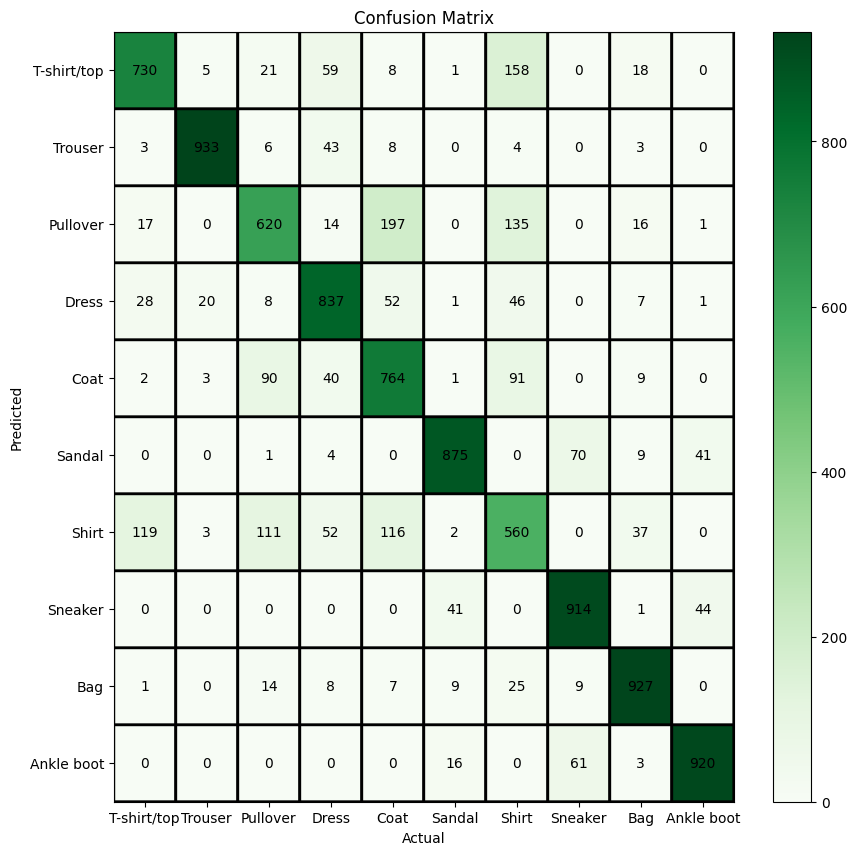

In [ ]:
#Logging confusion matrix to WandB
wandb.init()
wandb.log({"Confusion Matrix" : [wandb.Image(plot_confusion_matrix(labels, y_pred, y_test),caption=f"Confusion Matrix with test accuracy = {accuracy} and loss = {loss}")]})
wandb.finish()